<h1><center><strong><font color="black"> NLP Project : Topic 4 - Text Similarity </font></strong></center></h1>
<h1><center><font color="chillipepper"><strong>Evaluating prompt text generation</strong></font></center></h1>
<h3><center><font color="black"> Pauline Mendras - Clotilde Nietge</font></center></h3>

# Imports

In [4]:
import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg 
from scipy.special import binom
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
from sklearn.metrics import f1_score
from utils import *
#from williams import williams_test
OUTDATED_IGNORE=1

# Data visualization

In [5]:
# Importation of datasets
df_hanna_ann = pd.read_csv("Datasets/hanna_stories_annotations.csv")
df_hanna_scores = pd.read_csv("Datasets/hanna_metric_scores.csv", index_col="Model")

In [6]:
list_criteria = ["Relevance", "Coherence", "Surprise", "Empathy", "Engagement", "Complexity"]

In [7]:
df_hanna_ann.head(3)

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Worker ID,Assignment ID,Work time in seconds,Name
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,4,4,3,2,4,4,A2VE5IV9OD2SK1,3X87C8JFVHIT235KQ4UTS8264I6SQJ,579.0,None
1,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,5,5,1,3,4,1,A1IZ4NX41GKU4X,3DR23U6WEGL5K0SU6D4J8W9EM9LTE7,82.0,none
2,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,2,2,3,2,2,3,A264NN7JBX4UDQ,3UJ1CZ6IZSW49HMM6C6QUX7F7UV5SA,273.0,none


The dataset is composed of 96 prompts. For each prompt, 11 models (10 automated and 1 human) generate a story. This story has been evaluated 3 times by a human giving a mark from 1 to 5 for 6 criteria (Relevance, Coherence, Empathy, Surprise, Egagement, Complexity).

In [113]:
df_hanna_ann_avg = df_hanna_ann.groupby(["Story ID", "Prompt", "Human", "Model", "Story"])[list_criteria].mean().reset_index()
df_hanna_ann_avg

,Story ID,Prompt,Human,Model,Story,Relevance,Coherence,Surprise,Empathy,Engagement,Complexity
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...",Human,"3,000 years have I been fighting. Every mornin...",3.666667,3.666667,2.333333,2.333333,3.333333,2.666667
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...",Human,"“Dad, you 're on TV again !” I heard Eric 's v...",5.000000,4.666667,3.666667,4.000000,3.666667,4.000000
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...",Human,"When Tyler entered the ward, his daughter Vale...",4.666667,4.666667,4.333333,4.000000,4.000000,4.333333
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,Human,His body was failing. He had taken care of it ...,3.666667,4.000000,2.000000,3.000000,3.666667,4.000000
4,4,"You have become death, destroyer of worlds.","I saw the button. It was simple, red, no words...",Human,"I saw the button. It was simple, red, no words...",4.666667,5.000000,4.666667,3.000000,3.666667,3.666667
...,...,...,...,...,...,...,...,...,...,...,...
1051,1051,All you hear is a dripping noise.,All I hear is a dripping noise. At first it wa...,TD-VAE,"' I want no more.' she cried, tossing her cloa...",1.000000,2.666667,2.333333,2.000000,2.333333,3.000000
1052,1052,Google search engine always was alive. They re...,86388: *what am i* 86389: They ask me question...,TD-VAE,'it says. 'it repeats in every language the wo...,2.333333,2.333333,1.333333,1.333333,2.000000,1.666667
1053,1053,Heart of Eden,"If everything went perfectly right, her creati...",TD-VAE,opens almost a month after the start of Star T...,2.000000,3.666667,3.000000,2.333333,3.000000,2.333333
1054,1054,"When a new president is elected, they are give...",“Mr President I want you to know I am telling ...,TD-VAE,'said a puppet'President Bush stopped the old ...,3.000000,2.333333,2.666667,1.666667,1.666667,2.333333


In [125]:
def add_metrics(data_metrics, metrics, model) :
    new_col = []
    temp = data_metrics[metrics][model]
    temp = temp.replace('[', '')
    temp = temp.replace(']', '')
    temp = temp.replace(',', '')
    temp2 = temp.split()
    for elem in temp2 :
        new_col.append(float(elem))
    new_df_metrics = pd.DataFrame(new_col)
    new_df_metrics.columns = [metrics]
    return(new_df_metrics)

In [126]:
def concat_model(data, data_metrics, metrics, list_models = list(pd.unique(df_hanna_ann_avg.Model))) :
    new_df_ = pd.DataFrame(add_metrics(data_metrics, metrics, list_models[0]))
    for model in list_models[1::] : 
        new_df = add_metrics(df_hanna_scores, metrics, model)
        new_df_ = pd.concat([new_df_, new_df])
    new_df_ = new_df_.set_index(np.arange(0, new_df_.shape[0]))
    data = data.merge(new_df_, how = 'left', left_index=True, right_index=True)
    return(data)

In [143]:
list_metrics = list(df_hanna_scores.columns[7::])

In [144]:
for metric in list_metrics :
    df_hanna_ann_avg = concat_model(df_hanna_ann_avg, df_hanna_scores, metric, list_models = list(pd.unique(df_hanna_ann_avg.Model)))
df_hanna_ann_avg

,Story ID,Prompt,Human,Model,Story,Relevance,Coherence,Surprise,Empathy,Engagement,...,Repetition-2 ¤§,Repetition-3 ¤§,SUPERT-PS ¤ε,SUPERT-SS ¤ε,BLANC-Tune-PS ¤Δ,BLANC-Help-PS ¤Δ,BLANC-Tune-SS ¤Δ,BLANC-Help-SS ¤Δ,BARTScore-PS ¤Δ,BARTScore-SP ¤Δ
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...",Human,"3,000 years have I been fighting. Every mornin...",3.666667,3.666667,2.333333,2.333333,3.333333,...,0.104072,0.029289,0.360606,0.351396,0.000000,-0.026087,0.058824,-0.235294,-4.046356,-4.624497
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...",Human,"“Dad, you 're on TV again !” I heard Eric 's v...",5.000000,4.666667,3.666667,4.000000,3.666667,...,0.119850,0.036913,0.305898,0.329835,0.040984,0.000000,-0.142857,-0.142857,-4.839603,-6.575281
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...",Human,"When Tyler entered the ward, his daughter Vale...",4.666667,4.666667,4.333333,4.000000,4.000000,...,0.070659,0.020675,0.235848,0.273803,-0.011111,-0.011111,0.031250,0.000000,-4.854327,-4.772851
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,Human,His body was failing. He had taken care of it ...,3.666667,4.000000,2.000000,3.000000,3.666667,...,0.073027,0.013845,0.253024,0.245976,-0.002193,0.010965,0.125000,0.000000,-6.117441,-5.537744
4,4,"You have become death, destroyer of worlds.","I saw the button. It was simple, red, no words...",Human,"I saw the button. It was simple, red, no words...",4.666667,5.000000,4.666667,3.000000,3.666667,...,0.054878,0.011299,0.357535,0.357535,0.022472,-0.022472,0.600000,0.600000,-5.082365,-4.840554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,1051,All you hear is a dripping noise.,All I hear is a dripping noise. At first it wa...,TD-VAE,"' I want no more.' she cried, tossing her cloa...",1.000000,2.666667,2.333333,2.000000,2.333333,...,0.053824,0.001318,0.129021,0.138815,-0.003067,-0.027607,0.000000,0.000000,-5.673419,-6.898654
1052,1052,Google search engine always was alive. They re...,86388: *what am i* 86389: They ask me question...,TD-VAE,'it says. 'it repeats in every language the wo...,2.333333,2.333333,1.333333,1.333333,2.000000,...,0.048193,0.010753,0.252419,0.239887,0.000000,-0.019231,0.000000,0.000000,-5.116093,-5.711975
1053,1053,Heart of Eden,"If everything went perfectly right, her creati...",TD-VAE,opens almost a month after the start of Star T...,2.000000,3.666667,3.000000,2.333333,3.000000,...,0.031008,0.017857,0.124526,0.165431,0.000000,-0.032520,0.000000,0.000000,-5.513528,-9.977611
1054,1054,"When a new president is elected, they are give...",“Mr President I want you to know I am telling ...,TD-VAE,'said a puppet'President Bush stopped the old ...,3.000000,2.333333,2.666667,1.666667,1.666667,...,0.049587,0.026119,0.293137,0.276365,-0.013986,-0.006993,-0.037037,0.074074,-5.681099,-4.978225


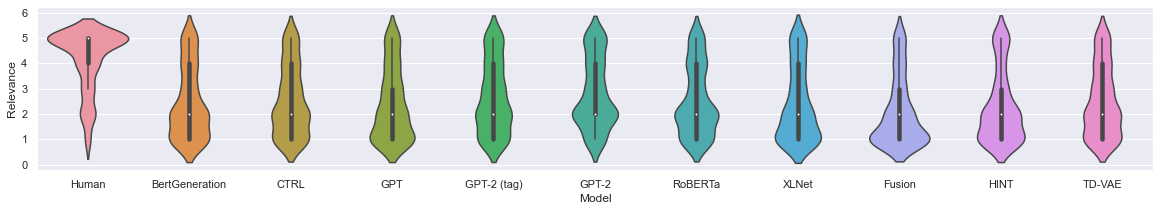

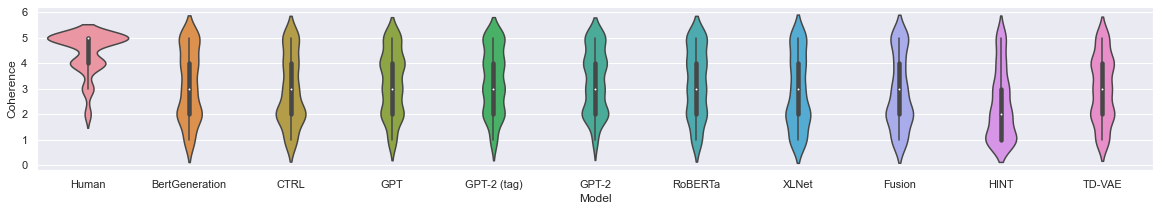

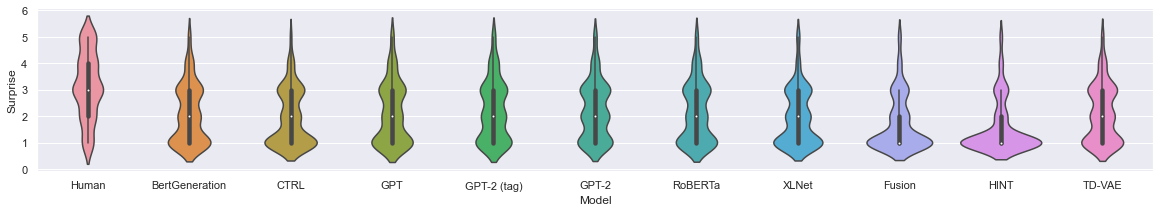

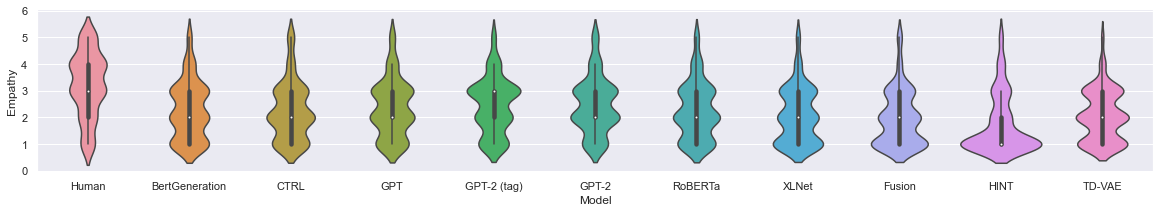

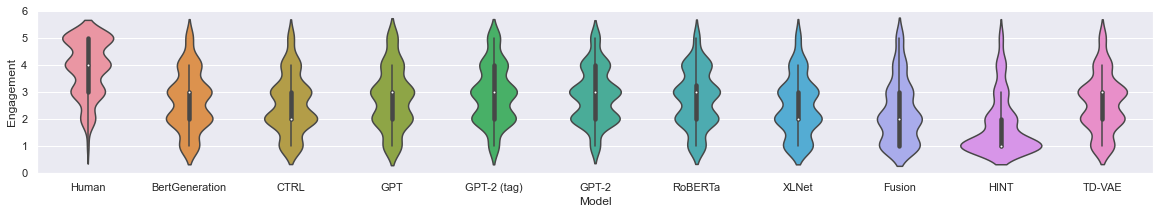

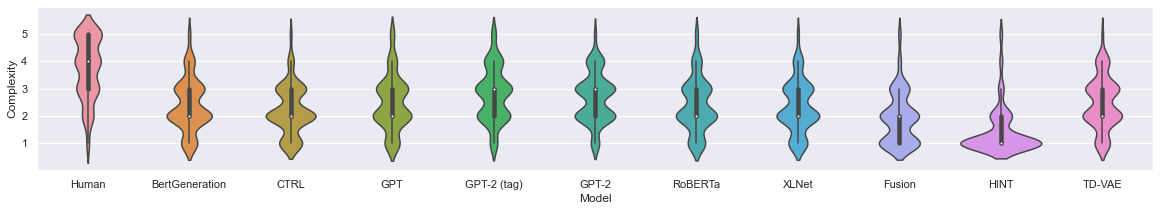

In [23]:
for criterion in list_criteria:
    sns.set(rc={"figure.figsize":(20, 3)})
    ax = sns.violinplot(x="Model", y=criterion, data=df_hanna_ann)
    plt.show()

## Correlations

Il est important d'enlever les outliers (le modèle humain)

In [55]:
df_scores_no_human = df_hanna_scores.drop(["Human"])

In [ ]:
# Définition of the 3 correlation coefficients
list_coef_corr = [pearsonr, spearmanr, kendalltau]

### Text-level correlation

In [60]:
def text_level_correlation(coef_corr, metric1, metric2, data):
    """return the story-level correlation between metric1 and metric2"""
    M1_text = np.array([json.loads(l) for l in data[metric1].tolist()]).T
    M2_text = np.array([json.loads(l) for l in data[metric2].tolist()]).T
    x = [coef_corr(M1_text[i], M2_text[i])[0] for i in range(M1_text.shape[0]) if not np.isnan(coef_corr(M1_text[i], M2_text[i])[0])]
    print("Coef {} between {} and {} : \n {} ".format(coef_corr, metric1, metric2, np.mean(x)))
    return(np.mean(x))

In [61]:
for coef_corr in list_coef_corr:
    text_level_correlation(coef_corr, "BLEU Ξ§", "Relevance", df_scores_no_human)

Coef <function pearsonr at 0x12fc19950> between BLEU Ξ§ and Relevance : 
 0.13138144738289825 
Coef <function spearmanr at 0x12fc1b050> between BLEU Ξ§ and Relevance : 
 0.1774777823789897 
Coef <function kendalltau at 0x12fc1ba70> between BLEU Ξ§ and Relevance : 
 0.13922033417177257 


### System Level

In [62]:
def system_level_correlation(coef_corr, metric1, metric2, data):
    """return the system-level correlation between metric1 and metric2"""
    M1_text = np.array([json.loads(l) for l in data[metric1].tolist()]).T
    M2_text = np.array([json.loads(l) for l in data[metric2].tolist()]).T
    corr = coef_corr(np.mean(M1_text, axis=0), np.mean(M2_text, axis=0))[0]
    print("Coef {} between {} and {} : \n {} ".format(coef_corr, metric1, metric2, corr))
    return(corr)

In [63]:
for coef_corr in list_coef_corr:
    system_level_correlation(coef_corr, "BLEU Ξ§", "Relevance", df_scores_no_human)

Coef <function pearsonr at 0x12fc19950> between BLEU Ξ§ and Relevance : 
 0.7988772238903901 
Coef <function spearmanr at 0x12fc1b050> between BLEU Ξ§ and Relevance : 
 0.7212121212121211 
Coef <function kendalltau at 0x12fc1ba70> between BLEU Ξ§ and Relevance : 
 0.5555555555555555 


## Interface correlation function

In [24]:
def get_correlation(correlation_type, Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, verbose=False, return_length=False):
    """return the system- or story- level correlation between metric1 and metric2"""
    assert correlation_type in CORRELATION_TYPES, "correlation_type must be in {}".format(CORRELATION_TYPES)
    if correlation_type == "system":
        return get_system_level_correlation(Kstr, metric1, metric2, df=df, verbose=verbose)
    elif correlation_type == "story":
        return get_story_level_correlation(Kstr, metric1, metric2, df=df, verbose=verbose)
    else:
        raise ValueError()

## Correlation DataFrame

In [25]:
def get_correlation_df(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA+METRICS, metrics_subset2=None, verbose=False):
    """returns the correlation DataFrame between metrics_subset1 and metrics_subset2,
       or the square correlation DataFrame of metrics_subset1 if metrics_susbet2 is None"""
    SYMMETRIC_DF = metrics_subset2 is None
    I = len(metrics_subset1)
    if SYMMETRIC_DF:
        J = I
        metrics_subset2 = metrics_subset1
    else:
        J = len(metrics_subset2)
    data = np.ones((I, J))
    for i in range(I):
        if SYMMETRIC_DF:
            for j in range(i):
                metric1 = metrics_subset1[i]
                metric2 = metrics_subset2[j]
                data[i][j] = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose)
                data[j][i] = data[i][j]
        else:
            for j in range(J):
                metric1 = metrics_subset1[i]
                metric2 = metrics_subset2[j]
                data[i][j] = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose)
    return pd.DataFrame(data, index=metrics_subset1, columns=metrics_subset2)

In [26]:
get_correlation_df("system", "kendall", df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS_FILTERED)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Relevance,0.555556,0.511111,0.555556,0.600000,0.555556,0.555556,0.600000,-0.422222,-0.555556,0.600000,0.333333,-0.511111,0.511111,-0.333333,-0.288889,0.111111,0.244444
Coherence,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Empathy,0.422222,0.466667,0.422222,0.466667,0.422222,0.511111,0.733333,-0.555556,-0.688889,0.377778,0.200000,-0.377778,0.555556,-0.200000,-0.155556,-0.022222,0.022222
Surprise,0.422222,0.466667,0.511111,0.555556,0.422222,0.511111,0.466667,-0.555556,-0.511111,0.466667,0.288889,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Engagement,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Complexity,0.539360,0.584307,0.629253,0.674200,0.539360,0.629253,0.404520,-0.674200,-0.449467,0.584307,0.404520,-0.314627,0.674200,-0.449467,-0.314627,-0.179787,-0.044947


In [27]:
# Ajout Pauline: corrélation avec Pearson
get_correlation_df("system", "pearson", df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS_FILTERED)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Relevance,0.798877,0.790972,0.776319,0.762958,0.753594,0.733719,0.673212,-0.670676,-0.650863,0.789947,0.716075,-0.607642,0.776243,-0.396191,-0.500028,0.290330,-0.111143
Coherence,0.738506,0.735252,0.719461,0.745555,0.780340,0.836491,0.869488,-0.873827,-0.879879,0.774057,0.570609,-0.660988,0.864701,-0.736499,-0.783498,-0.454586,-0.750157
Empathy,0.773016,0.745916,0.725024,0.736863,0.809636,0.827221,0.861684,-0.861967,-0.899616,0.788340,0.610461,-0.727534,0.878312,-0.634484,-0.682967,-0.272418,-0.606669
Surprise,0.805086,0.841146,0.831991,0.873878,0.824351,0.910923,0.888746,-0.907123,-0.845573,0.860580,0.769825,-0.697924,0.926483,-0.729530,-0.843661,-0.251919,-0.621568
Engagement,0.812584,0.817247,0.807437,0.832873,0.843066,0.908170,0.920706,-0.934389,-0.911444,0.848558,0.699043,-0.759186,0.924440,-0.780298,-0.839974,-0.400835,-0.740132
Complexity,0.868328,0.904891,0.897045,0.924549,0.903020,0.954887,0.903852,-0.956274,-0.881906,0.924822,0.801520,-0.754682,0.938346,-0.748309,-0.827365,-0.329182,-0.681254


In [28]:
# Ajout Pauline: corrélation avec Spearman
get_correlation_df("system", "spearman", df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS_FILTERED)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Relevance,0.721212,0.696970,0.733333,0.745455,0.721212,0.709091,0.781818,-0.612121,-0.709091,0.757576,0.442424,-0.648485,0.696970,-0.539394,-0.393939,0.163636,0.296970
Coherence,0.575758,0.600000,0.624242,0.660606,0.575758,0.636364,0.709091,-0.660606,-0.696970,0.600000,0.272727,-0.357576,0.684848,-0.490909,-0.369697,-0.187879,-0.103030
Empathy,0.600000,0.624242,0.612121,0.624242,0.600000,0.636364,0.818182,-0.684848,-0.806061,0.587879,0.272727,-0.466667,0.721212,-0.321212,-0.260606,-0.006061,-0.018182
Surprise,0.624242,0.648485,0.672727,0.721212,0.624242,0.696970,0.624242,-0.721212,-0.684848,0.648485,0.357576,-0.345455,0.684848,-0.466667,-0.369697,-0.212121,-0.127273
Engagement,0.575758,0.600000,0.624242,0.660606,0.575758,0.636364,0.709091,-0.660606,-0.696970,0.600000,0.272727,-0.357576,0.684848,-0.490909,-0.369697,-0.187879,-0.103030
Complexity,0.717329,0.747724,0.796356,0.826752,0.717329,0.778119,0.559273,-0.814593,-0.644380,0.765961,0.528878,-0.413376,0.802435,-0.547115,-0.413376,-0.218846,-0.060791


## Best metrics

In [29]:
def print_best_metrics(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, n_best=5, latex=False, verbose=False):
    """prints the `n_best` best metrics for each criterion for the corresponding `correlation_type` and `Kstr`"""
    corr = get_correlation_df(correlation_type, Kstr, df=df, verbose=verbose)
    for criterion in CRITERIA:
        print(criterion)
        if latex:
            print((100*corr.abs().sort_values(criterion, ascending=False)[criterion].drop(CRITERIA).head(n_best)).round(2).to_latex())
        else:
            print(corr.abs().sort_values(criterion, ascending=False)[criterion].drop(CRITERIA).head(n_best))

In [30]:
print_best_metrics("system", "kendall")

Relevance
S3-Pyramid ΞΔ             0.6
chrF Ξ§                   0.6
ROUGE-SU* Recall Ξ§       0.6
ROUGE-S* Recall Ξ§        0.6
ROUGE-W-1.2 F-Score Ξ§    0.6
Name: Relevance, dtype: float64
Coherence
BaryScore-SD-0.001 Ξε    0.777778
BaryScore-SD-5 Ξε        0.688889
BaryScore-SD-10 Ξε       0.688889
BaryScore-SD-1 Ξε        0.644444
BaryScore-SD-0.5 Ξε      0.600000
Name: Coherence, dtype: float64
Empathy
BaryScore-SD-0.001 Ξε    0.777778
BERTScore F1 Ξε          0.733333
BaryScore-SD-0.01 Ξε     0.733333
MoverScore Ξε            0.733333
BaryScore-W Ξε           0.688889
Name: Empathy, dtype: float64
Surprise
BaryScore-SD-0.001 Ξε    0.777778
BaryScore-SD-5 Ξε        0.688889
BaryScore-SD-10 Ξε       0.688889
BaryScore-SD-1 Ξε        0.644444
Novelty-1 ¤§             0.600000
Name: Surprise, dtype: float64
Engagement
BaryScore-SD-0.001 Ξε    0.777778
BaryScore-SD-5 Ξε        0.688889
BaryScore-SD-10 Ξε       0.688889
BaryScore-SD-1 Ξε        0.644444
BaryScore-SD-0.5 Ξε      0.6000

In [31]:
# Ajout Pauline: meilleure metric pour chaque critère, en utilisant Pearson
print_best_metrics("system", "pearson")

Relevance
ROUGE-S* F-Score Ξ§     0.803880
ROUGE-SU* F-Score Ξ§    0.802857
ROUGE-S* Recall Ξ§      0.802400
ROUGE-SU* Recall Ξ§     0.802318
BLEU Ξ§                 0.798877
Name: Relevance, dtype: float64
Coherence
BaryScore-SD-0.01 Ξε    0.881516
BaryScore-W Ξε          0.879879
BERTScore F1 Ξε         0.879075
DepthScore Ξε           0.873827
MoverScore Ξε           0.869488
Name: Coherence, dtype: float64
Empathy
BaryScore-SD-0.01 Ξε     0.900108
BaryScore-W Ξε           0.899616
BERTScore F1 Ξε          0.886716
SUPERT-Golden ΞΔ         0.881030
ROUGE-WE-3 F-Score Ξε    0.879258
Name: Empathy, dtype: float64
Surprise
BARTScore-SH ΞΔ        0.926483
BERTScore Recall Ξε    0.910923
DepthScore Ξε          0.907123
SUPERT-Golden ΞΔ       0.898288
Compression ¤§         0.892367
Name: Surprise, dtype: float64
Engagement
DepthScore Ξε       0.934389
BARTScore-SH ΞΔ     0.924440
SUPERT-Golden ΞΔ    0.922095
MoverScore Ξε       0.920706
BERTScore F1 Ξε     0.917393
Name: Engagement, dtyp

In [32]:
# Ajout Pauline: meilleure metric pour chaque critère, en utilisant Spearman
print_best_metrics("system", "spearman")

Relevance
MoverScore Ξε          0.781818
S3-Pyramid ΞΔ          0.757576
ROUGE-S* Recall Ξ§     0.757576
ROUGE-SU* Recall Ξ§    0.757576
chrF Ξ§                0.745455
Name: Relevance, dtype: float64
Coherence
BaryScore-SD-0.001 Ξε    0.927273
BaryScore-SD-5 Ξε        0.781818
BaryScore-SD-10 Ξε       0.781818
BaryScore-SD-1 Ξε        0.757576
BERTScore F1 Ξε          0.745455
Name: Coherence, dtype: float64
Empathy
BaryScore-SD-0.001 Ξε    0.927273
BERTScore F1 Ξε          0.842424
BaryScore-SD-0.01 Ξε     0.842424
MoverScore Ξε            0.818182
BaryScore-W Ξε           0.806061
Name: Empathy, dtype: float64
Surprise
BaryScore-SD-0.001 Ξε    0.903030
BaryScore-SD-5 Ξε        0.830303
BaryScore-SD-10 Ξε       0.830303
BaryScore-SD-1 Ξε        0.793939
BaryScore-SD-0.5 Ξε      0.769697
Name: Surprise, dtype: float64
Engagement
BaryScore-SD-0.001 Ξε    0.927273
BaryScore-SD-5 Ξε        0.781818
BaryScore-SD-10 Ξε       0.781818
BaryScore-SD-1 Ξε        0.757576
BERTScore F1 Ξε      

Pauline: intéressant, il y a des différences ! A commenter

## Figures

In [33]:
def print_correlation_heatmap(correlation_type, Kstr, df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS,
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None):
    """prints the correlation heatmap"""
    sns.set(font_scale=font_scale)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=figsize)
        corr = (100*get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2)).round().abs()
        if metrics_subset2 is None:
            mask = np.zeros_like(corr)
            mask[np.triu_indices_from(mask, k=1)] = True
            if use_mask:
                ax = sns.heatmap(corr, mask=mask, square=True, annot=True, vmin=0, vmax=100, fmt='g',
                                 xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
            else:
                ax = sns.heatmap(corr, square=True, annot=True, vmin=0, vmax=100, fmt='g',
                                 xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
        else:
            corr.loc['Average'] = corr.mean().round().abs()
            ax = sns.heatmap(corr, annot=True, square=True, vmin=0, vmax=100, fmt='g',
                             xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        if savepath is not None:
            plt.savefig("figures/{}_{}_{}.png".format(savepath, correlation_type, Kstr), bbox_inches='tight')
        else:
            plt.show()
        plt.clf()

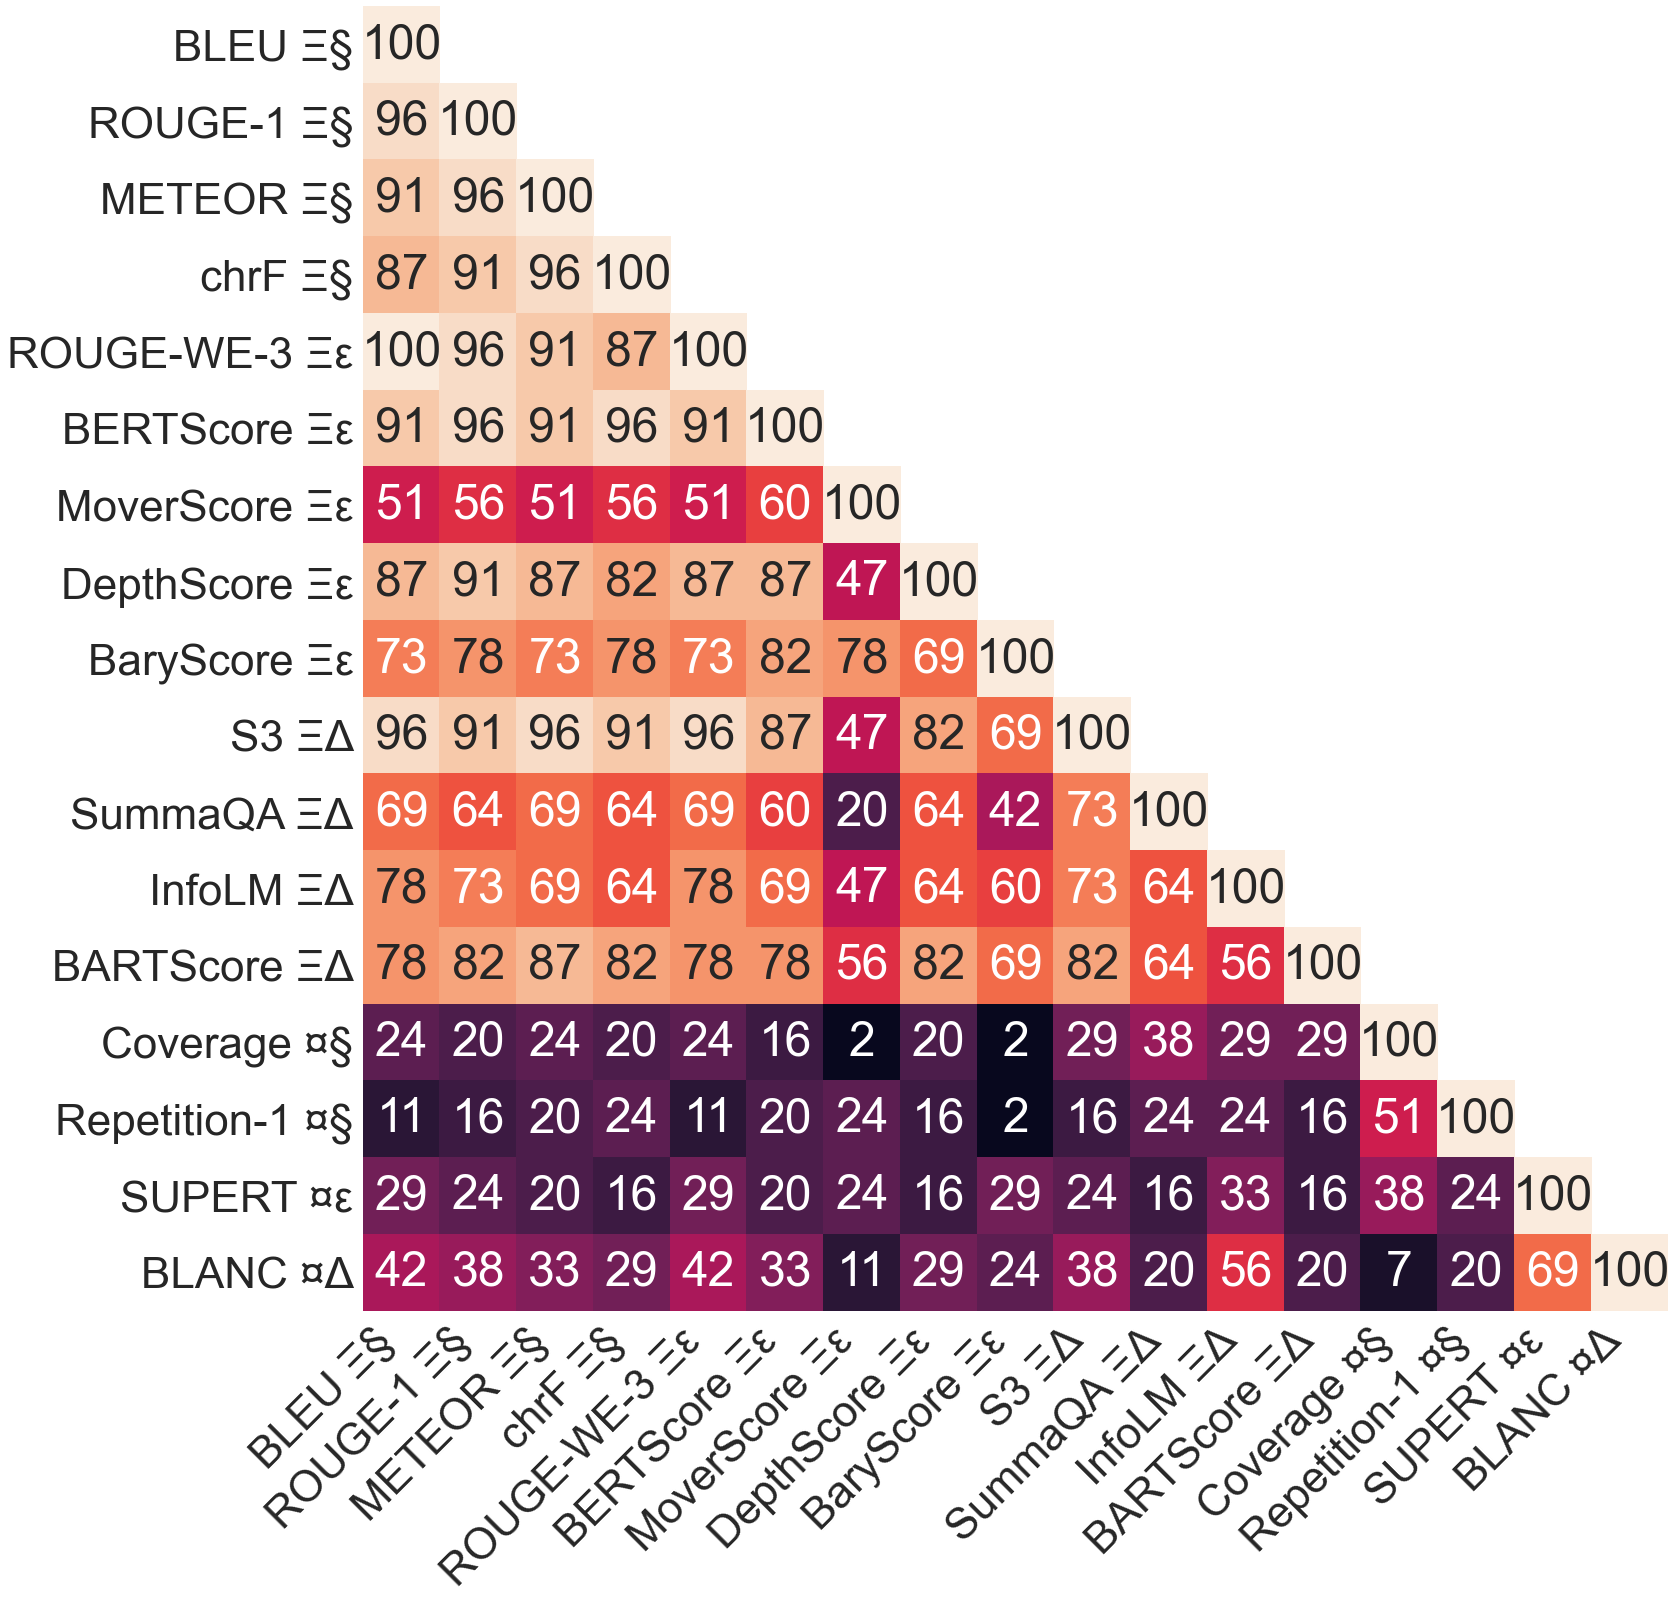

<Figure size 1440x216 with 0 Axes>

In [34]:
print_correlation_heatmap("system", "kendall", df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS, 
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None)

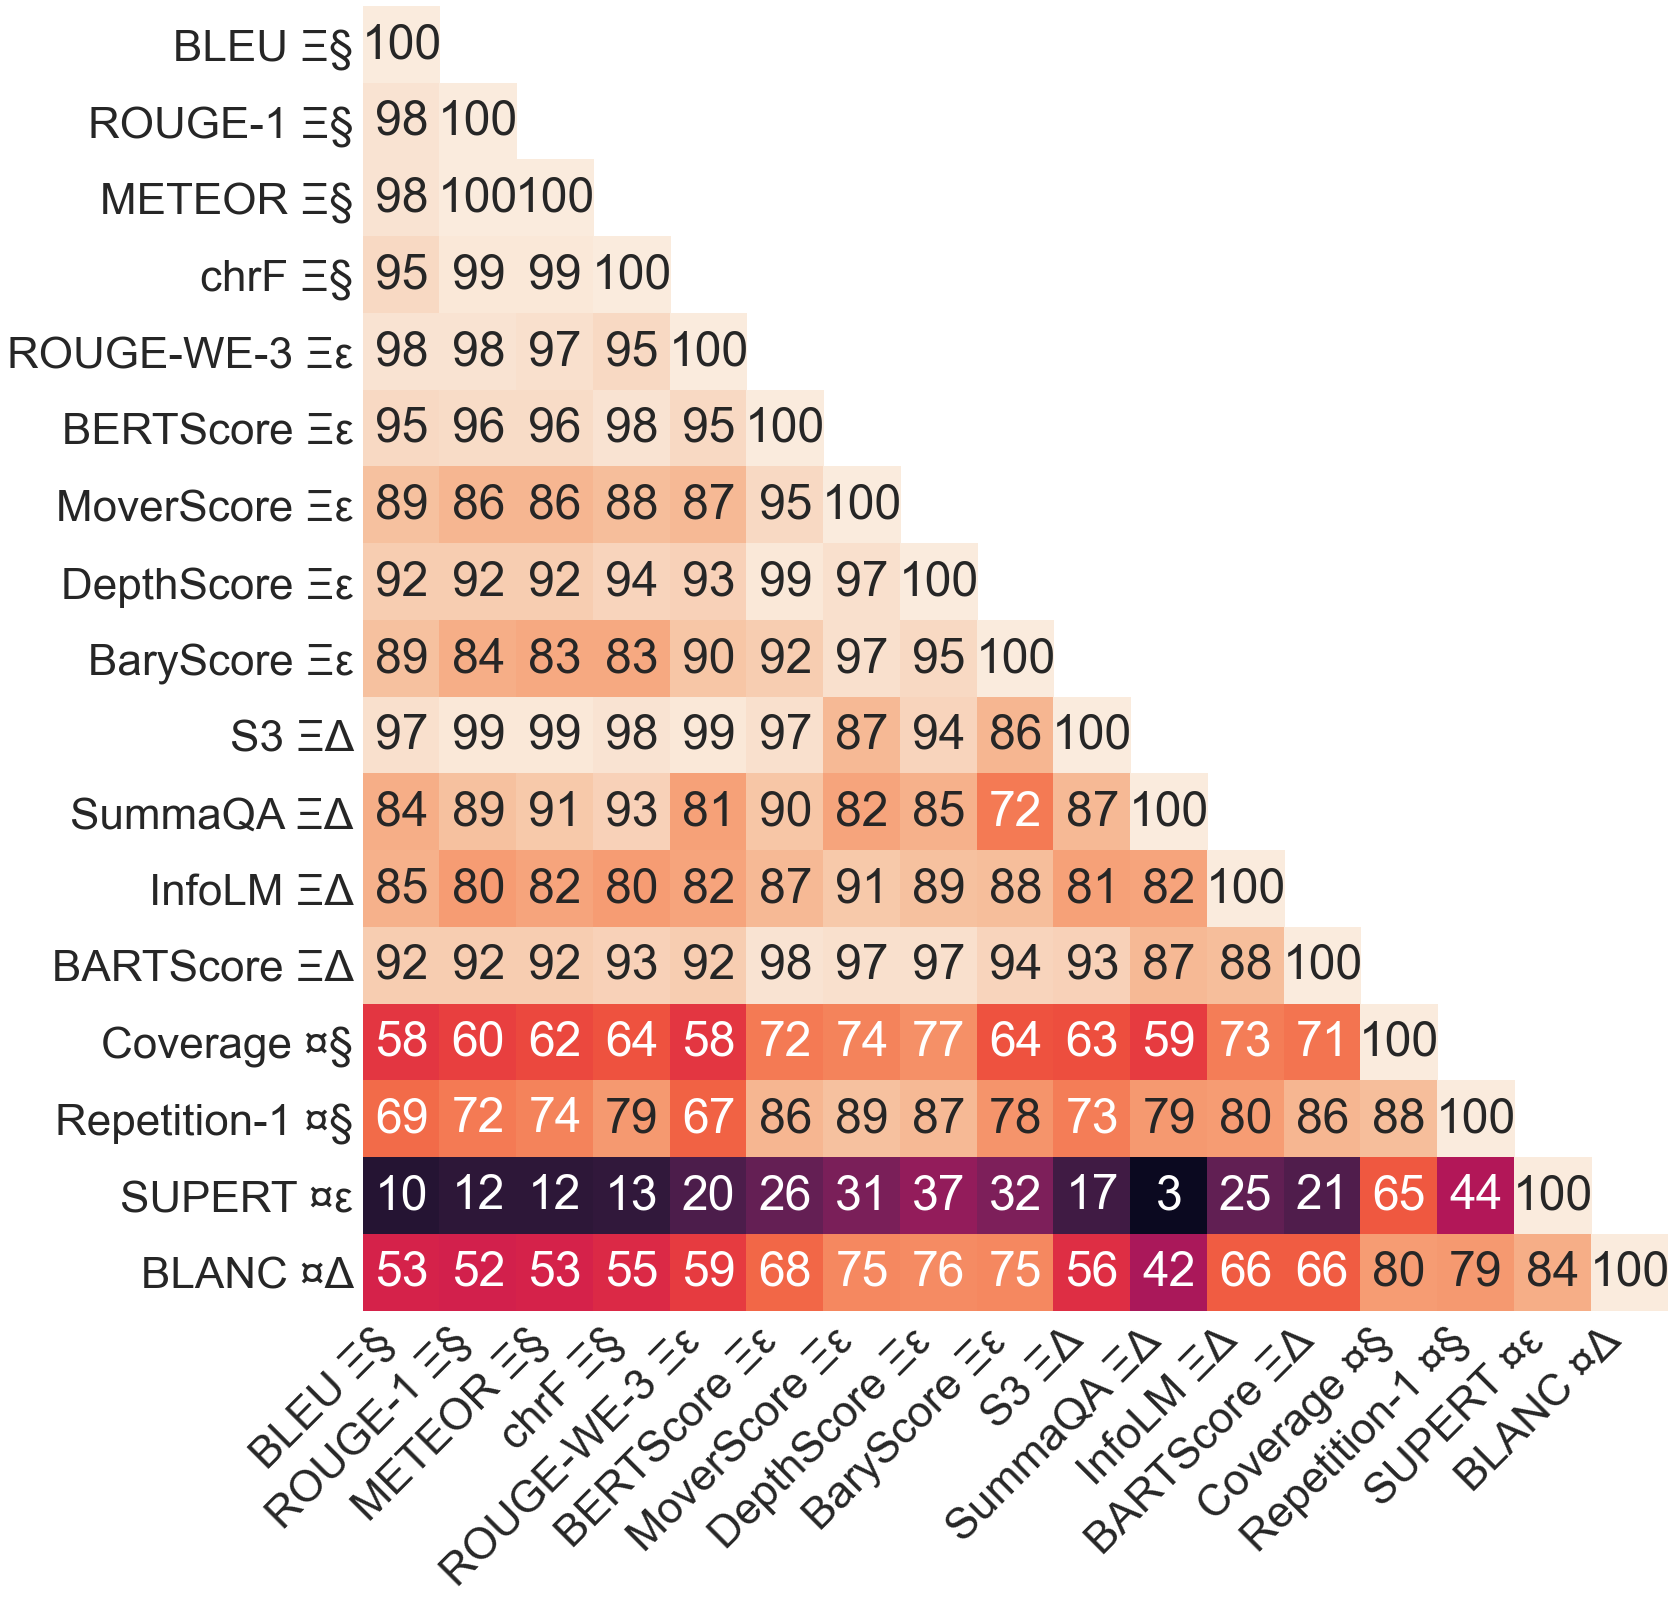

<Figure size 1440x216 with 0 Axes>

In [35]:
# Ajout Pauline: On fait la même avec Pearson
print_correlation_heatmap("system", "pearson", df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS, 
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None)

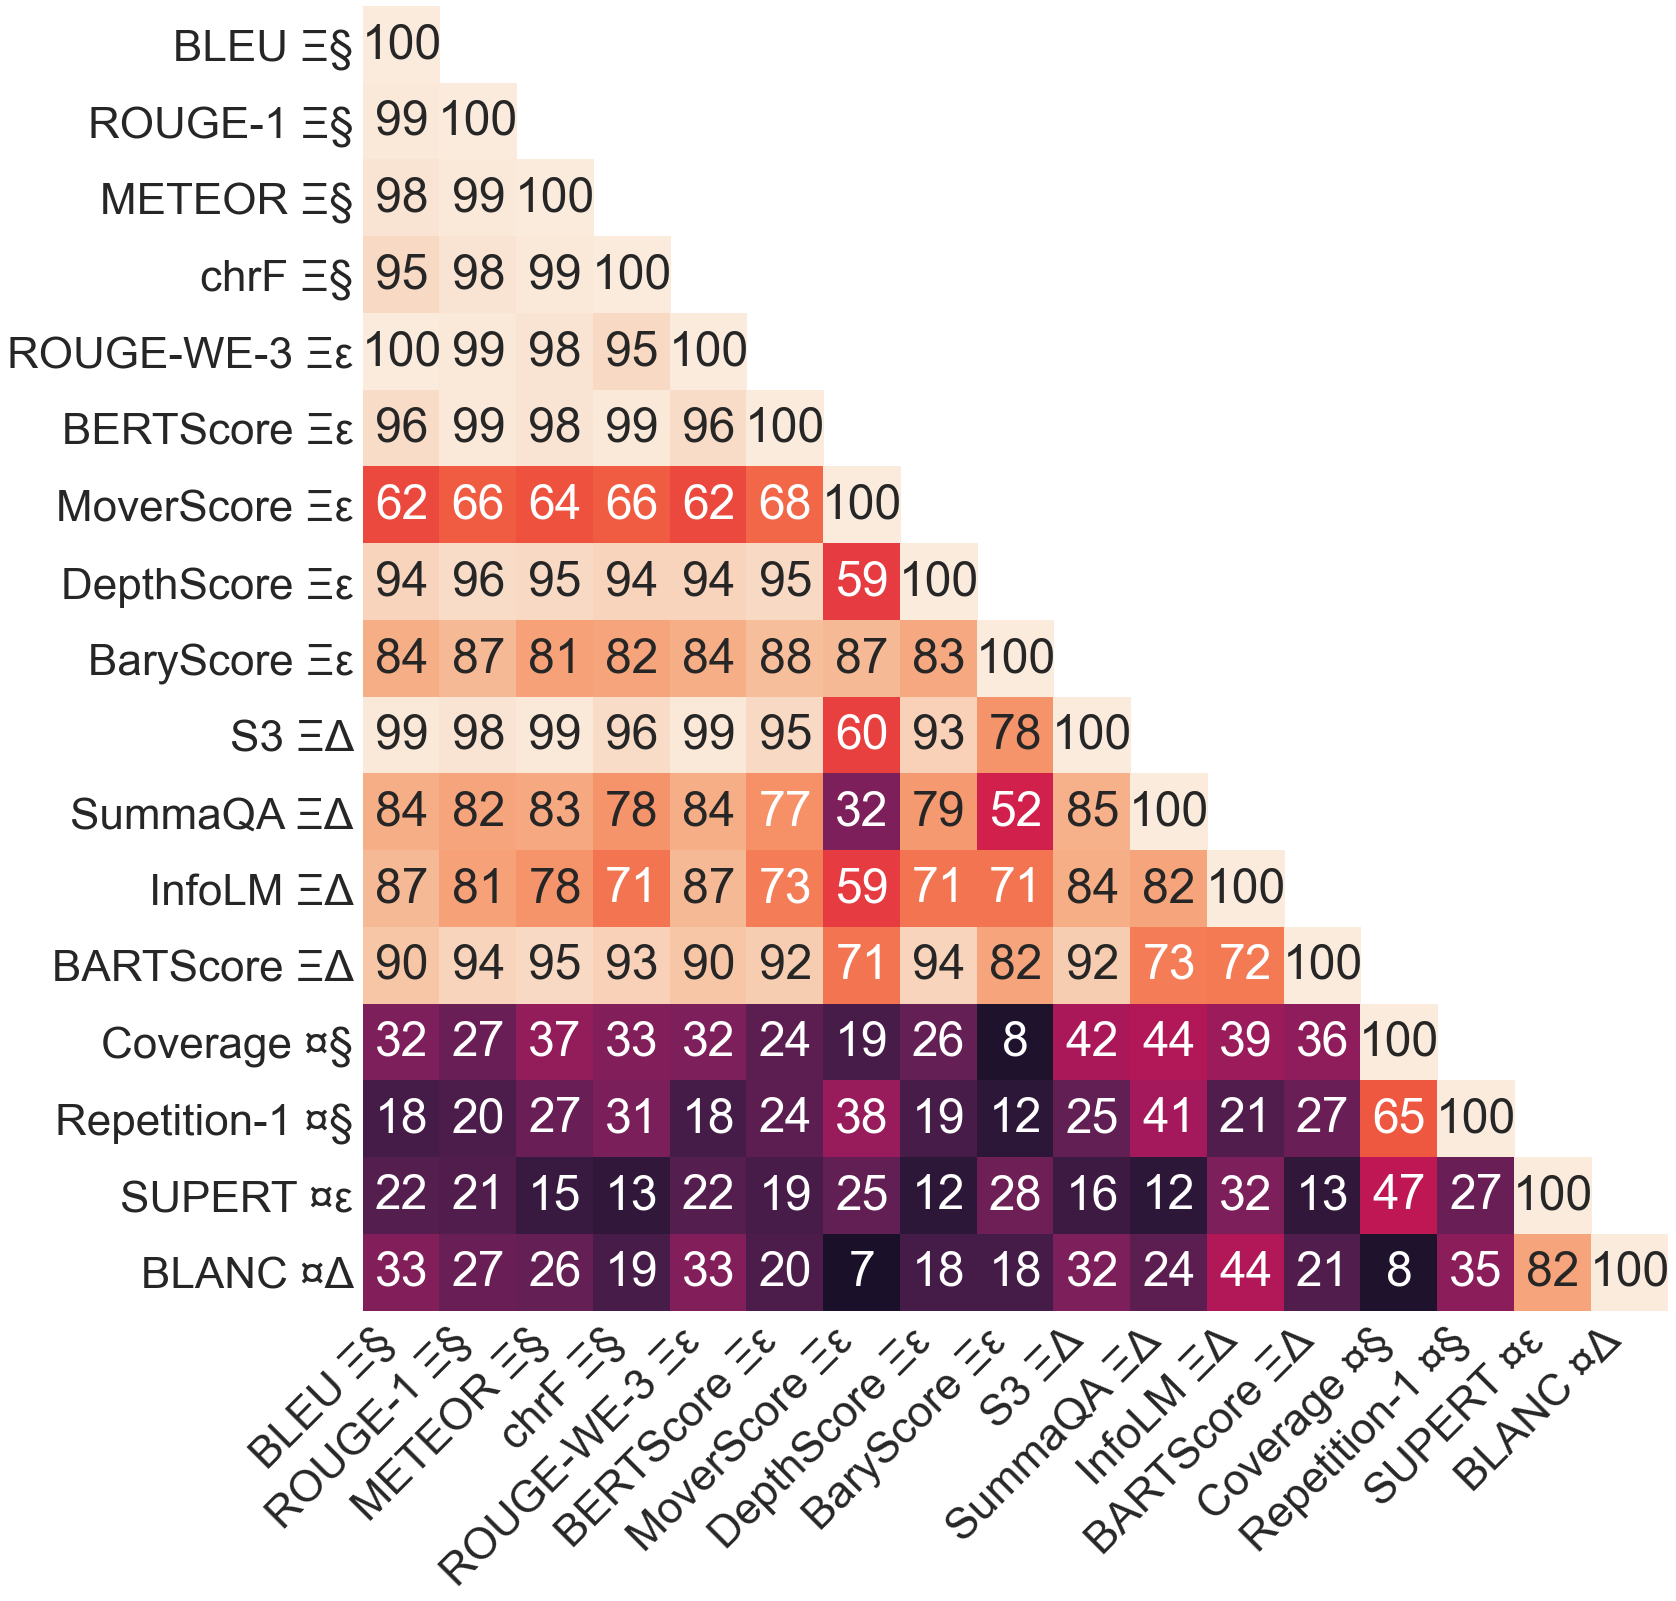

<Figure size 1440x216 with 0 Axes>

In [36]:
# Ajout Pauline: On fait la même avec Spearman
print_correlation_heatmap("system", "spearman", df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS, 
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None)

In [37]:
# METRICS_FILTERED
METRICS_FILTERED_HEATMAPS_ALL = False
if METRICS_FILTERED_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_FILTERED_DF_NO_HUMAN, 
                                  metrics_subset1=METRICS_FILTERED_LABELS,
                                  metrics_subset2=None,
                                  xticklabels=METRICS_FILTERED_LABELS,
                                  yticklabels=METRICS_FILTERED_LABELS,
                                  use_mask=True, font_scale=4, figsize=(25,24),
                                  savepath=None)

In [38]:
# METRICS
METRICS_HEATMAPS_ALL = False
if METRICS_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=METRICS_LABELS,
                                  metrics_subset2=None,
                                  xticklabels=METRICS_LABELS,
                                  yticklabels=METRICS_LABELS,
                                  use_mask=True, font_scale=2, figsize=(39,40),
                                  savepath=None)

In [39]:
# CRITERIA
CRITERIA_HEATMAPS_ALL = False
if CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=None,
                                  xticklabels=CRITERIA_LABELS,
                                  yticklabels=CRITERIA_LABELS,
                                  use_mask=True, font_scale=2, figsize=(6,5),
                                  savepath=None)

In [40]:
# METRICS_FILTERED and CRITERIA
METRICS_FILTERED_CRITERIA_HEATMAPS_ALL = False
if METRICS_FILTERED_CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=METRICS_FILTERED,
                                  xticklabels=METRICS_FILTERED_LABELS,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=2.5, figsize=(13,5),
                                  savepath=None)

In [41]:
# METRICS and CRITERIA
METRICS_CRITERIA_HEATMAPS_ALL = False
if METRICS_CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=METRICS_LABELS,
                                  xticklabels=METRICS_LABELS,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=1.8, figsize=(30,7),
                                  savepath=None)

## Williams

Pauline: on garde cette partie ? J'ai pas réussi à importer le package williams

In [42]:
def get_williams_tp(correlation_type, Kstr, metric1, metric2, metric3, df=METRICS_DF_NO_HUMAN, verbose1=False, verbose2=False):
    """returns the Williams test for the significance of the increase in correlation between r12 and r13"""
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
        
    r12 = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose2)
    r13 = get_correlation(correlation_type, Kstr, metric1, metric3, df=df, verbose=verbose2)
    sign = np.sign(r12) * np.sign(r13)
    r12 = np.abs(r12)
    r13 = np.abs(r13)
    r23 = sign * get_correlation(correlation_type, Kstr, metric2, metric3, df=df, verbose=verbose2)
    
    if correlation_type == "system":
        n = data1.shape[1]
    elif correlation_type == "story":
        n = data1.shape[0]
    else:
        raise ValueError()
    if verbose1:
        print("r12: {}, r13: {}, r23: {}, n: {}".format(r12, r13, r23, n))
    if n <= 3:
        return None, None
    if r12 == r13:
        t, p = None, None
    elif r12 > r13:
        t, p = williams_test(r12, r13, r23, n)
    elif r12 < r13:
        t, p = williams_test(r13, r12, r23, n)
    if verbose1:
        print("1: {}, 2: {}, 3: {}, t: {}, p: {}".format(metric1, metric2, metric3, t, p))
        if p > 0.05:
            print("p > 0.05: not significant increase")
        else:
            print("p < 0.05: significant increase")
    
    return t, p

In [43]:
_ = get_williams_tp("system", "pearson", "Relevance", "BERTScore F1 Ξε", "ROUGE-1 Recall Ξ§", verbose1=True)

r12: 0.69886591627576, r13: 0.7909720918180811, r23: 0.9145073764921344, n: 10


NameError: name 'williams_test' is not defined

In [24]:
_ = get_williams_tp("system", "pearson", "Empathy", "BERTScore F1 Ξε", "BLEU Ξ§", verbose1=True)

r12: 0.8867156172959242, r13: 0.7730162713288586, r23: 0.9387296182166223, n: 10
1: Empathy, 2: BERTScore F1 Ξε, 3: BLEU Ξ§, t: 2.00020039909911, p: 0.042797013860609856
p < 0.05: significant increase


In [26]:
def get_williams_matrices(correlation_type, Kstr, metric1, df=METRICS_DF_NO_HUMAN, labels=METRICS, verbose1=False, verbose2=False):
    """returns the matrics containing the Williams test values"""
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
    williams_t = np.zeros((len(labels), len(labels)))
    williams_p = np.zeros((len(labels), len(labels)))    
        
    for i, metric2 in enumerate(labels):
        r12 = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose2)
        for j, metric3 in enumerate(labels[:i]):
            if correlation_type == "system":
                n = data1.shape[1]
            elif correlation_type == "summary":
                n = data1.shape[0]
            else:
                n = np.min([
                        get_correlation(correlation_type, Kstr, metric1, metric2, df=df, return_length=True)[1],
                        get_correlation(correlation_type, Kstr, metric1, metric3, df=df, return_length=True)[1],
                        get_correlation(correlation_type, Kstr, metric2, metric3, df=df, return_length=True)[1]
                    ])
            r13 = get_correlation(correlation_type, Kstr, metric1, metric3, df=df, verbose=verbose2)
            sign = np.sign(r12) * np.sign(r13)
            r12 = np.abs(r12)
            r13 = np.abs(r13)
            r23 = sign * get_correlation(correlation_type, Kstr, metric2, metric3, df=df, verbose=verbose2)
            if verbose1:
                print("{}, {}, {}, {}".format(r12, r13, r23, n))
            if n <= 3:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r12 == r13:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r12 > r13:
                t, p = williams_test(r12, r13, r23, n)
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r13 > r12:
                t, p = williams_test(r13, r12, r23, n)
                williams_t[j][i] = t
                williams_p[j][i] = p
            else:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            if np.isnan(williams_p[i][j]):
                williams_p[i][j] = 0
            if np.isnan(williams_p[j][i]):
                williams_p[j][i] = 0
            if verbose1:
                print("2: {}, 3: {}, t: {}, p: {}".format(metric2, metric3, t, p))
    
    return williams_t, williams_p

In [27]:
def print_significance_heatmap(williams_p, labels=METRICS, font_scale=1.5, figsize=(40,40), save_path=None):
    sns.set(font_scale=font_scale)
    n = len(williams_p)
    fig, ax = plt.subplots(figsize=figsize)   
    eps = 1e-20
    boundaries = [0, eps, 0.05, 1]
    colors = ["#FFFFFF", "#00441B", "#e1fcd6"]
    norm = matplotlib.colors.BoundaryNorm(boundaries=boundaries, ncolors=256)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    annot = np.array([["{}".format(int(np.round(100*williams_p[i][j]))) if not (williams_p[i][j] == 0 or np.isnan(williams_p[i][j])) else "" for j in range(n) ] for i in range(n)])
    mask = np.isnan(williams_p)
    sns.heatmap(pd.DataFrame(williams_p, index=labels[:n], columns=labels[:n]), mask=mask, linewidths=.5, annot=annot, square=True, fmt='', cmap=cmap, norm=norm, cbar=False, ax=ax)
    plt.xticks(rotation=45, ha="right")
    if save_path is None:
        plt.show()
    else:
        fig.savefig(save_path, bbox_inches='tight') 
    plt.clf()

D:\projects\story-evaluation\hanna\williams.py:49: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(2*K*(n-1)/(n-3) + (((r12+r13)**2)/4)*((1-r23)**3))


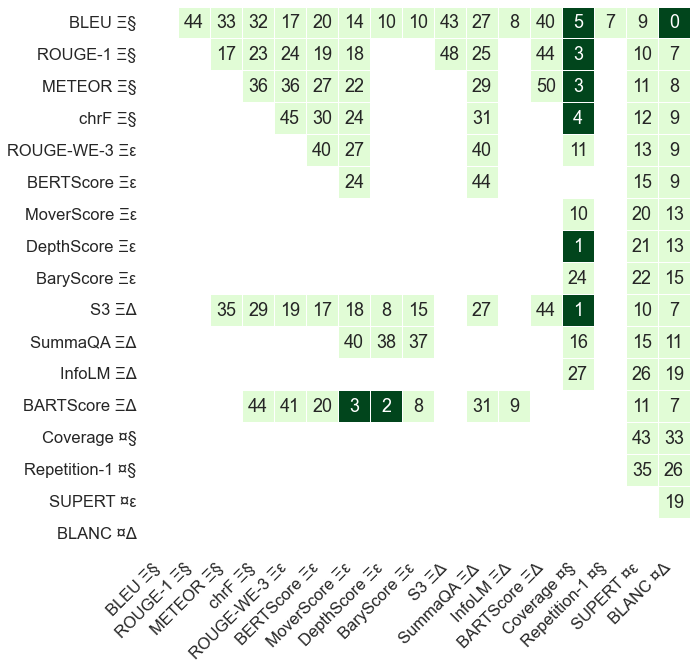

<Figure size 432x288 with 0 Axes>

In [28]:
williams_t, williams_p = get_williams_matrices("system", "pearson", "Relevance", df=METRICS_DF_NO_HUMAN, labels=METRICS_FILTERED, verbose1=False, verbose2=False)
print_significance_heatmap(williams_p, labels=METRICS_FILTERED_LABELS, font_scale=1.5, figsize=(10,10))

In [168]:
WILLIAMS_ALL = False
if WILLIAMS_ALL:
    for correlation_type in CORRELATION_TYPES:
        print("======= {} =======".format(correlation_type))
        for Kstr in CORRELATIONS:
            print("------ {} ------".format(Kstr))
            for criterion in CRITERIA:
                print(criterion)
                williams_t, williams_p = get_williams_matrices(correlation_type, KStr, criterion, verbose1=False, verbose2=False)
                print_significance_heatmap(williams_p, save_path="figures/williams_{}_{}_{}".format(correlation_type, KStr, criterion))

## Ranking DFs

In [44]:
RESET_RANKINGS = False

In [45]:
if RESET_RANKINGS:        
    df_dict = {}
    for correlation_type in CORRELATION_TYPES:
        for Kstr in CORRELATIONS:
            corr = get_correlation_df(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=METRICS, metrics_subset2=CRITERIA, verbose=False)
            old_columns = corr.columns.copy()
            corr.columns = [t + "_{}_{}".format(correlation_type, Kstr) for t in old_columns]
            df_dict["{}_{}".format(correlation_type, Kstr)] = corr.abs()

In [46]:
if RESET_RANKINGS:
            
    for k in df_dict.keys():
        df_dict[k].to_csv("rankings/{}.csv".format(k), index_label="Model")
        
    for correlation_type in CORRELATION_TYPES:
        correlation_type_df = None
        for k in df_dict.keys():
            if correlation_type in k:
                if correlation_type_df is None:
                    correlation_type_df = df_dict[k]
                else:
                    correlation_type_df = correlation_type_df.join(df_dict[k], lsuffix='_caller', rsuffix='_other')
        correlation_type_df.to_csv("rankings/{}.csv".format(correlation_type), index_label="Model")
    
    for KStr in CORRELATIONS:
        KStr_df = None
        for k in df_dict.keys():
            if KStr in k:
                if KStr_df is None:
                    KStr_df = df_dict[k]
                else:
                    KStr_df = KStr_df.join(df_dict[k], lsuffix='_caller', rsuffix='_other')
        KStr_df.to_csv("rankings/{}.csv".format(KStr), index_label="Model")
        
    for criterion in CRITERIA:
        criterion_df = None
        for k in df_dict.keys():
            if criterion_df is None:
                criterion_df = pd.DataFrame(df_dict[k]["{}_{}".format(criterion, k)])
            else:
                criterion_df = criterion_df.join(pd.DataFrame(df_dict[k]["{}_{}".format(criterion, k)]), lsuffix='_caller', rsuffix='_other')
        criterion_df.to_csv("rankings/{}.csv".format(criterion), index_label="Model")
        
    global_df = None
    for k in df_dict.keys():
        if global_df is None:
            global_df = df_dict[k]
        else:
            global_df = global_df.join(df_dict[k], lsuffix='_caller', rsuffix='_other')
    global_df.to_csv("rankings/{}.csv".format("global"), index_label="Model")

In [47]:
dataframes = os.listdir("rankings")  # remove the folder `.ipynb_checkpoints` is present

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'rankings'

In [48]:
def perm_to_rank(systems, mean_rank):
    return [systems[mean_rank.tolist().index(i)] for i in range(len(mean_rank))][::-1]

In [49]:
mean_rankings_dict = {}
one_level_rankings_dict = {}
mean_scores_dict = {}
one_level_scores_dict = {}

for df_name in dataframes:
    df_to_rank = pd.read_csv("rankings/{}".format(df_name))
    systems = list(df_to_rank.Model.values.tolist())
    mean_rank, mean_scores = mean_aggregation_task_level(df_to_rank)
    one_level_rank, one_level_borda_scores = ranking_aggregation(df_to_rank, return_count=True)
    mean_rankings_dict[df_name[:-4]] = perm_to_rank(systems, mean_rank)
    one_level_rankings_dict[df_name[:-4]] = perm_to_rank(systems, one_level_rank)
    mean_scores_dict[df_name[:-4]] = perm_to_rank(mean_scores, mean_rank)
    one_level_scores_dict[df_name[:-4]] = perm_to_rank(one_level_borda_scores, one_level_rank)

NameError: name 'dataframes' is not defined

In [50]:
def print_rankings(k, ranking_type, topn=5):
    if ranking_type == "mean":
        print(k, list(zip(mean_rankings_dict[k][:topn], mean_scores_dict[k][:topn])))
    elif ranking_type == "one_level":
        print(k, list(zip(one_level_rankings_dict[k][:topn], one_level_scores_dict[k][:topn])))
    else:
        raise ValueError()

In [51]:
print_rankings("system", "one_level")

KeyError: 'system'

In [52]:
def print_all_rankings(ranking_type, topn=5):
    print_rankings("global", ranking_type, topn=topn)
    for ctype in CORRELATION_TYPES:
        for KStr in CORRELATIONS:
            print_rankings("{}_{}".format(ctype, KStr), ranking_type, topn=topn)
    for ctype in CORRELATION_TYPES:
        print_rankings(ctype, ranking_type, topn=topn)
    for KStr in CORRELATIONS:
        print_rankings(KStr, ranking_type, topn=topn)
    for criterion in CRITERIA:
        print_rankings(criterion, ranking_type, topn=topn)

In [53]:
PRINT_ONE_LEVEL = True
if PRINT_ONE_LEVEL:
    print_all_rankings("one_level", topn=5)

KeyError: 'global'

In [54]:
PRINT_MEAN = False
if PRINT_MEAN:
    print_all_rankings("mean", topn=5)

# Paired bootstrap test

In [55]:
def bootstrap_test(s1, s2, n, seed=42, df=METRICS_FILTERED_DF_NO_HUMAN, alpha=0.05):
    "returns the bootstrap test for systems 1 and 2"""
    rng = np.random.default_rng(seed)
    scores = np.zeros((len(df.columns), 3))
    for _ in range(n):
        indices = np.random.choice(np.arange(N_STORIES), N_STORIES)
        for i, m in enumerate(df.columns):
            score1 = np.mean(np.array(json.loads(df[m][s1]))[indices])
            score2 = np.mean(np.array(json.loads(df[m][s2]))[indices])
            if score1 > score2:
                scores[i, 0] += 1
            elif score2 > score1:
                scores[i, 1] += 1
            else: 
                scores[i, 2] += 1
    labels = np.zeros(len(df.columns))
    for i, _ in enumerate(df.columns):
        if scores[i, 0] >= (1-alpha) * n:
            labels[i] = 1
        elif scores[i, 1] >= (1-alpha) * n:
            labels[i] = 2
        else:
            labels[i] = 0
    return labels

In [56]:
def global_bootstrap_test(n, seed=42, df=METRICS_FILTERED_DF_NO_HUMAN, metrics=METRICS_FILTERED, alpha=0.05, verbose=False):
    MODELS2 = MODELS[1:]  # remove human from models
    all_labels = np.zeros((int(binom(len(MODELS2), 2)), len(df.columns)))
    pair_i = 0
    for i1, s1 in enumerate(MODELS2):
        for i2, s2 in enumerate(MODELS2[:i1]):
            if verbose:
                print("Pair {} of {}: {} vs {}".format(pair_i+1, int(binom(len(MODELS2), 2)), s1, s2))
            all_labels[pair_i] = bootstrap_test(s1, s2, n, seed=seed, df=df, alpha=alpha)
            pair_i += 1
    fscores = np.zeros((len(CRITERIA), len(metrics)))
    for i in range(len(CRITERIA)):
        for j in range(len(metrics)):
            fscores[i, j] = f1_score(all_labels[:,i], all_labels[:,j+len(CRITERIA)], average="weighted")
    return all_labels, fscores

In [57]:
def print_bootstrap_fscores_heatmap(df=METRICS_FILTERED_DF_NO_HUMAN, metrics=METRICS_FILTERED, 
                                    font_scale=2.5, figsize=(13,5), savepath=None, verbose=False):
    """prints the bootstrap f-scores heatmap"""
    all_labels, fscores = global_bootstrap_test(1000, seed=42, df=df, metrics=metrics, alpha=0.05, verbose=verbose)
    sns.set(font_scale=font_scale)
    fig, ax = plt.subplots(figsize=figsize)
    corr = np.round(100*np.vstack([fscores, np.mean(fscores, axis=0)]))
    ax = sns.heatmap(corr, annot=True, square=True, vmin=0, vmax=100, fmt='g',
                     xticklabels=METRICS_FILTERED_LABELS, yticklabels=CRITERIA_LABELS+["Avg"], cbar=False)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath, bbox_inches='tight')
    return all_labels, fscores

In [58]:
BOOTSTRAP_FILTERED = False
if BOOTSTRAP_FILTERED:
    _, _ = print_bootstrap_fscores_heatmap()

In [59]:
BOOTSTRAP = False
if BOOTSTRAP:
    _, _ = print_bootstrap_fscores_heatmap(df=METRICS_DF_NO_HUMAN, metrics=METRICS, font_scale=1.7, figsize=(30,7))

# Top-k systems

In [60]:
SYSTEM_AVERAGES_DF = full_data_df.groupby(['Model']).mean().round(2)[CRITERIA]
SYSTEM_AVERAGES_DF = SYSTEM_AVERAGES_DF.drop(labels="Human")
SYSTEM_AVERAGES_DF

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity
Model,,,,,,
BertGeneration,2.46,3.14,2.28,2.09,2.67,2.41
CTRL,2.54,2.93,2.26,1.93,2.53,2.23
Fusion,2.09,2.86,1.99,1.72,2.27,1.92
GPT,2.40,3.22,2.37,2.13,2.76,2.49
GPT-2,2.81,3.29,2.47,2.21,2.86,2.68
GPT-2 (tag),2.67,3.31,2.47,2.22,2.92,2.80
HINT,2.29,2.38,1.74,1.56,1.75,1.45
RoBERTa,2.54,3.22,2.27,2.12,2.74,2.41
TD-VAE,2.51,2.99,2.07,2.10,2.59,2.49


In [61]:
def get_correlation_df_topk(k, criterion, correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS, verbose=False):
    """returns the correlation DataFrame between top-k systems"""
    topk_systems = SYSTEM_AVERAGES_DF.sort_values(criterion, ascending=False).index[:k]
    df = df.loc[topk_systems]
    return get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, verbose=verbose)

In [62]:
def analysis_topk(a, b, correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA, metrics_subset2=METRICS, verbose=False, step=2, absolute=True):
    """returns the dictionary containing the correlations between criteria and metrics between top-k systems"""
    topk_dict = {}
    k_range = round((b-a)/step)
    for criterion in CRITERIA:
        topk_matrix = np.zeros((k_range, len(metrics_subset2)))
        for i, k in enumerate(range(a, b, step)):
            corr = get_correlation_df_topk(k, criterion, correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, verbose=verbose)
            if absolute:
                corr = corr.abs()
            topk_matrix[i] = corr.loc[criterion]
        topk_dict[criterion] = topk_matrix
    return topk_dict

In [63]:
def facet_plot_topk(a, b, correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                    metrics_subset1=CRITERIA, metrics_subset2=METRICS,
                    step=2, topk_dict=None, absolute=True,
                    savepath=None, verbose=False):
    if topk_dict is None:
        topk_dict = analysis_topk(a, b, correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, verbose=verbose, step=step, absolute=absolute)
    k_range = round((b-a)/step)
    datas = []
    for abbr, criterion in zip(CRITERIA_LABELS, CRITERIA):
        arrays = [
            len(metrics_subset2) * list(range(a,b,step)),
            [metrics_subset2[i//k_range] for i in range(len(metrics_subset2) * k_range)],
            len(metrics_subset2) * k_range * [abbr]
        ]
        df_index = pd.MultiIndex.from_arrays(arrays, names=('k', 'metric', 'criterion'))
        data = pd.DataFrame(topk_dict[criterion].T.flatten(), index=df_index, columns=['r'])
        data.reset_index(inplace=True)
        datas.append(data)
    plot_df = pd.concat(datas, ignore_index=True)
    sns.set(font_scale=2.3)
    pl = sns.relplot(
        data=plot_df,
        x="k", y="r", 
        hue="metric", col="criterion",
        style="metric",
        kind="line", palette="deep",
        markers=8*["o"], dashes=False
    )
    if absolute:
        pl.set(
            yticks=[0, 0.25, 0.5, 0.75, 1],
            xticks=[4,6,8,10]
        )
    else:
        pl.set(
            yticks=[-1, -0.5, 0, 0.5, 1],
            xticks=[4,6,8,10]
        )
    (pl.set_titles("{col_name}").tight_layout(w_pad=0.8))
    sns.move_legend(pl, "lower center", bbox_to_anchor=(0.445, -0.1), ncol=8, title=None, frameon=False)
    plt.ylabel("r", rotation=90)
    plt.xlim(10, 4)
    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath, bbox_inches='tight')
    return plot_df

In [64]:
METRICS_FILTERED_LABELS2 = [
    "BLEU Ξ§", "ROUGE-1 Ξ§", "chrF Ξ§", "BERTScore Ξε", "BaryScore Ξε", "S3 ΞΔ", "BARTScore ΞΔ", "SUPERT ¤ε"
]

METRICS_FILTERED_DF_NO_HUMAN2 = METRICS_FILTERED_DF_NO_HUMAN[CRITERIA + METRICS_FILTERED_LABELS2]

AttributeError: module 'seaborn' has no attribute 'move_legend'

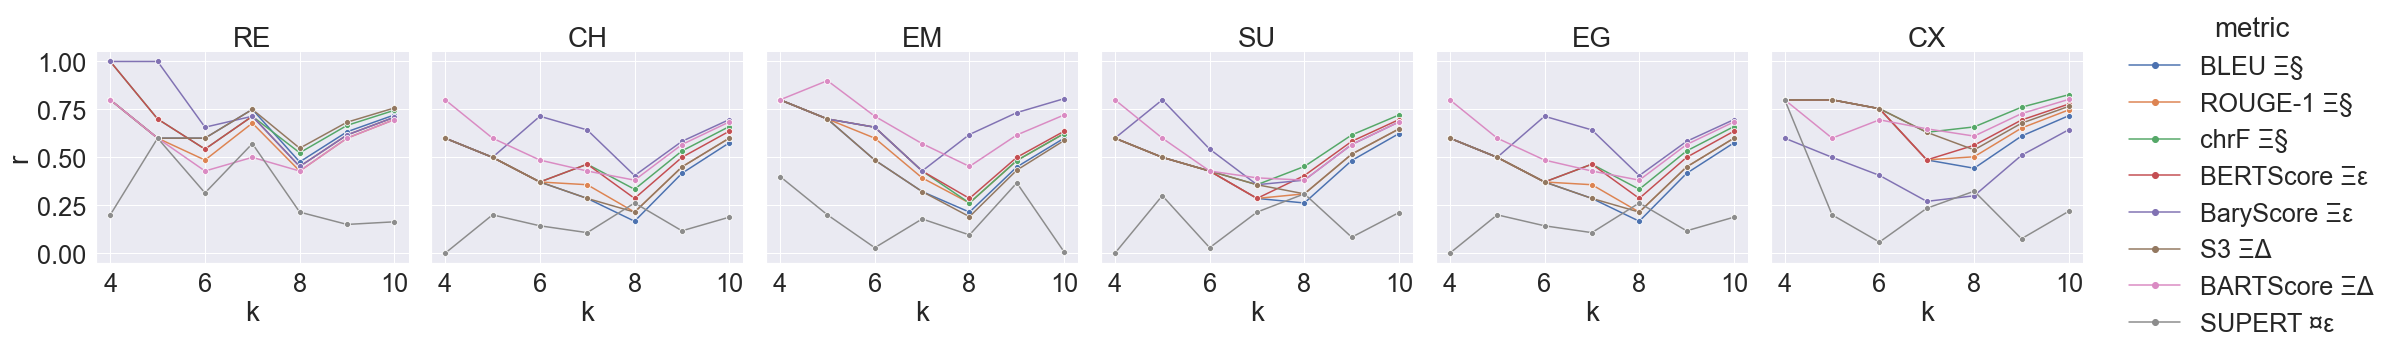

In [65]:
facet_plot_topk(4, 11, "system", "spearman", df=METRICS_FILTERED_DF_NO_HUMAN2, metrics_subset1=CRITERIA, metrics_subset2=METRICS_FILTERED_LABELS2, verbose=False, step=1)